In [36]:
import numpy as np
from copy import deepcopy
import dsbcorr
import pandas as pd
import fnmatch
from collections import Counter, defaultdict
import random
import networkx as nx
import importlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import hdbscan
import os
import json
import matplotlib as mpl

random.seed(42)
np.random.seed(42)

In [37]:
time = int(7200)

experiment = ('cp_cpuhog_sin_3')


# Some of the data has CPU usage in json format that needs to be processed, some is preprocessed in csv format
if os.path.exists(f"../data/{experiment}/cpu_usage.json"):
    file = (f"../data/{experiment}/cpu_usage.json")

    f = open(file)
    
    data = json.load(f)
    f.close()
    
    f_dict = {}
    data = data['data']['result']
    for ent in range(len(data)):
        if data[ent]['metric']['id'] != "/":
            f_dict[data[ent]['metric']['pod']] = np.zeros((len(data[ent]['values']), 2))
            f_dict[data[ent]['metric']['pod']][:, 0] = [float(x[0]) for x in data[ent]['values']]
            f_dict[data[ent]['metric']['pod']][:, 1] = [float(x[1]) for x in data[ent]['values']]
    
    for service in f_dict:
        if data[0]["metric"]["__name__"] == "container_memory_rss":
            pass
        else:
            temp = [0]
            for i in range(1, np.shape(f_dict[service])[0]):
                temp.append(f_dict[service][i, 1] - f_dict[service][i - 1, 1])
            f_dict[service][:, 1] = deepcopy(temp)
            f_dict[service][:, 1] = dsbcorr.sub_sample_zeros(f_dict[service][:, 1])
    
    max_len = 0
    for i in f_dict:
        if len(f_dict[i]) > max_len:
            max_len = len(f_dict[i])
    
    aligned_data = dsbcorr.align_data(f_dict, 5, time)
    service_list = []
    for s in aligned_data:
        service_list.append(s)

    X = np.zeros((int((time / 5) ), len(service_list)))
    ind = 0
    for s in service_list:
        X[:, ind] = aligned_data[s][:, 1]
        ind += 1
        
    cpu_df = pd.DataFrame(X[1:], columns=service_list)
else:
    cpu_df = pd.read_csv(
        f"../data/{experiment}/cpu_usage.csv", parse_dates=["time"], index_col="time"
    )
    
# Get fault time
with open(f"../data/{experiment}/fault_inject.txt", "r") as f:
    fault_t = int(f.read())

In [38]:
# Drop nginx, jaeger, elasticsearch services as we're interested only in non-monitoring services
misc_patterns = ["nginx*", "jaeger*", "socialnetwork-elasticsearch*"]
keep_cols = [
    c for c in cpu_df.columns
    if not any(fnmatch.fnmatchcase(c, pat) for pat in misc_patterns)
]
df = cpu_df[keep_cols]

# Convert pod names to nice naming scheme for readability
bases = ["-".join(c.split("-")[:-2]) for c in df.columns]
totals = Counter(bases)

indices = defaultdict(int)
new_cols = []
for base in bases:
    if totals[base] > 1:
        indices[base] += 1
        new_cols.append(f"{base}-{indices[base]}")
    else:
        new_cols.append(base)

df.columns = new_cols

def split_base(name):
    parts = name.split("-")
    return parts[:-1] + [int(parts[-1]) if parts[-1].isdigit() else parts[-1]]

df = df.reindex(columns=sorted(df.columns, key=split_base))
df = df.reset_index(drop=True)

# Clean data by imputating missing values
df_zero_na = df.replace(0, np.nan)
df_interpolated = df_zero_na.interpolate(method='linear', axis=0, limit_direction='both')
df_imputed = df_interpolated.fillna(method='ffill').fillna(method='bfill')

C:\Users\Giles\AppData\Local\Temp\ipykernel_17876\1356718913.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputed = df_interpolated.fillna(method='ffill').fillna(method='bfill')


In [39]:
# Parameters for FC-ADL
win = 360
step = 1
thr = 0.1
df = df_imputed.diff()
df = df.iloc[1:]

var_map = {var: i for var, i in enumerate(df.columns)}

data_arr = np.array(df)
data_arr[np.where(data_arr < 1e-3)] = 0

r_dict = dsbcorr.rolling_window(
    data_arr, win, "tapered", step, thr, False, "pearsons"
)

# Create strictly positive adj
r_pos = {}
for corr in r_dict:
    r_pos[corr] = deepcopy(r_dict[corr])
    r_pos[corr] = r_pos[corr] + 1
    r_pos[corr] = r_pos[corr] / 2

Windows:   0%|          | 0/1078 [00:00<?, ?it/s]D:\Documents\PhD\Code\socialNetwork_explore\dsbcorr.py:182: RuntimeWarning: invalid value encountered in divide
  R = temp / np.sqrt(np.dot(R, R.T))
Windows: 100%|██████████| 1078/1078 [00:00<00:00, 3151.64it/s]


In [40]:
eps = 1e-2

def compute_affinity_matrix(A, eps=eps):
    """
    A: (n×n) numpy array, nonnegative adjacency
    returns S = (I + eps^2 D − eps A)^{-1}
    """
    n = A.shape[0]
    # degree diag
    deg = A.sum(axis=1)
    D = sp.diags(deg)
    I = sp.eye(n, format='csr')
    M = I + (eps**2)*D - eps*sp.csr_matrix(A)
    # factorize and invert via n solves
    factor = spla.factorized(M)
    S = np.zeros((n, n))
    for i in range(n):
        e = np.zeros(n)
        e[i] = 1.0
        S[:, i] = factor(e)
    return S

S_dict = {w: compute_affinity_matrix(A) for w, A in r_pos.items()}

# Matusita distances for landmarks and points
landmarks = random.sample(list(r_pos.keys()), len(r_pos) // 4)
n_land = len(landmarks)
n_win  = len(r_pos)

dist = np.zeros((n_land, n_win))
all_windows = list(r_pos.keys())

for i, wi in enumerate(landmarks):
    Si_sqrt = np.sqrt(S_dict[wi])
    for j, wj in enumerate(all_windows):
        Sj_sqrt = np.sqrt(S_dict[wj])
        dist[i, j] = np.linalg.norm(Si_sqrt - Sj_sqrt)


# Embed in 2D for visualisation
coords = dsbcorr.LMDS(dist, landmarks, 2)

D:\Documents\PhD\Code\socialNetwork_explore\.venv\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


C:\Users\Giles\AppData\Local\Temp\ipykernel_17876\1634505600.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(type_color, n)


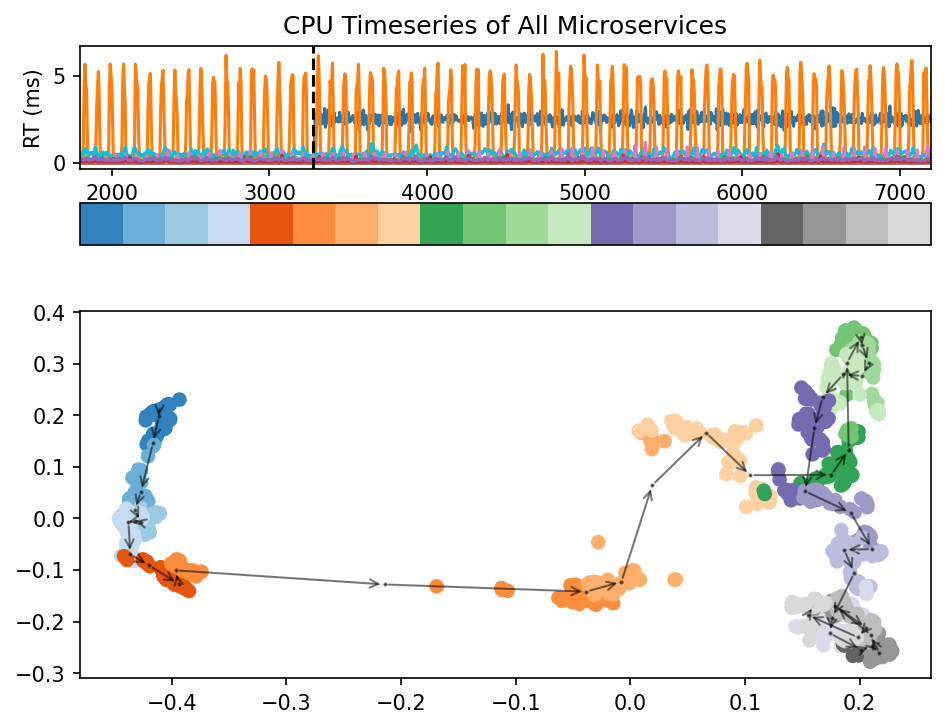

In [41]:
cmap_type = "tab20c"
# Finalized plot
fig, ax = plt.subplot_mosaic('AAA;BBB;CCC', gridspec_kw=dict(
    height_ratios=[1, 0.1, 3]), dpi=150)

cpu_data = np.array(df_imputed)

n = len(r_pos)
type_color = "tab20c"
cmap = cm.get_cmap(type_color, n)
cmap = cmap.reversed()
t = np.arange(0, n)
plt.tight_layout()
fin = int(np.floor(len(X)/step)*step)
ax['A'].set_ylabel('RT (ms)')
ax['A'].set_title('CPU Timeseries of All Microservices')
ax['A'].set_xlabel("Time (s)")
# ax['A'].plot(range(win*5,len(data_arr)*5,5),np.array(average_response_time_per_second[362:])/1000,'crimson', alpha=0.5, linewidth=1)
ax['A'].plot(range(0, len(cpu_data)*5, 5), cpu_data)

# ax['A'].set_ylim(ymax=300)
ax['A'].set_xlim(xmin=win*5)
ax['A'].set_xlim(xmax=len(cpu_data)*5)
# cmap = cm.get_cmap(type_color, np.shape(X)[1])
# colors = [cmap(i) for i in range(np.shape(X)[1])]
# for i, j in enumerate(ax['A'].lines):
#     j.set_color(colors[i])

ax['A'].axvline(fault_t*5, color='k',linestyle='--')

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(int(win*5), time),
                                          cmap=cmap_type),
                    ax=ax['B'],
                    orientation='horizontal',
                    fraction=3.5,
                    pad=0,
                    )
ax['B'].set_visible(False)

cbar.ax.tick_params(size=0)
cbar.set_ticks([])

ax['C'].scatter(coords[:, 0], coords[:, 1], c=t, cmap=cmap_type, alpha=1)

n_pts = 25
if n_pts > 0:
    prev_x = np.mean(coords[0:n_pts, 0])
    prev_y = np.mean(coords[0:n_pts, 1])
    for i in range(10, len(coords), n_pts):
        curr_x = np.mean(coords[i:i+n_pts, 0])
        curr_y = np.mean(coords[i:i+n_pts, 1])
        ax['C'].plot([prev_x, curr_x], [prev_y, curr_y], 'k', alpha=0.5, linewidth=0.1)
        ax['C'].plot(prev_x, prev_y, 'k.', markersize=2, alpha=0.5)
        ax['C'].annotate("",
                              xytext=(prev_x, prev_y),
                              xy=(curr_x, curr_y),
                              arrowprops=dict(arrowstyle="->", color='k', alpha=0.5, linewidth=1))
        prev_x = curr_x
        prev_y = curr_y

plt.show()

D:\Documents\PhD\Code\socialNetwork_explore\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Documents\PhD\Code\socialNetwork_explore\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


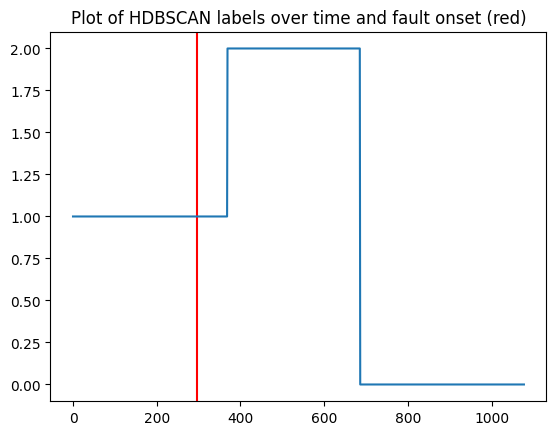

In [42]:
# HDBSCAN clustering example
S_dict = {w: compute_affinity_matrix(A) for w, A in r_pos.items()}
all_windows = list(r_pos.keys())

S_sqrt = np.stack([np.sqrt(S_dict[w]) for w in all_windows], axis=0)
n, m, _ = S_sqrt.shape
S_flat = S_sqrt.reshape(n, m * m)

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=max(5, len(r_pos) // 5),
    min_samples=5,
    metric='euclidean',
    prediction_data=True,
    core_dist_n_jobs=-1
)

labels = clusterer.fit_predict(S_flat)
arr = np.array(labels)

plt.axvline(fault_t-win, color='r')
plt.plot(arr)
plt.title("Plot of HDBSCAN labels over time and fault onset (red)")
plt.show()

In [43]:
is_outlier = labels == -1
valid = ~is_outlier
changes = np.where((labels[:-1] != labels[1:]) & valid[:-1] & valid[1:])[0]

changepoint = changes[0] + 1
new_labels = np.zeros_like(labels)
new_labels[changepoint:] = 1
new_labels[is_outlier] = -1

labels=new_labels

normal_lbl = 0
abnorm_lbl = 1

all_windows = list(r_pos.keys())

normal_idxs = np.where(labels == normal_lbl)[0]
abn_idxs = np.where(labels == abnorm_lbl)[0]

# average the adjacency matrix for normal and abnormal
def cluster_centroid(idxs):
    M_sum = np.zeros_like(r_dict[all_windows[0]])
    for i in idxs:
        win_key = all_windows[i]
        M_sum += r_dict[win_key]
    return M_sum / len(idxs)

normal_mat = cluster_centroid(normal_idxs)
abnormal_mat = cluster_centroid(abn_idxs)

normal_mat = normal_mat / np.max(normal_mat)
normal_mat[np.where((normal_mat < thr) & (normal_mat > -thr))] = 0

abnormal_mat = abnormal_mat / np.max(abnormal_mat)
abnormal_mat[np.where((abnormal_mat < thr) & (abnormal_mat > -thr))] = 0

sub_G = abnormal_mat - normal_mat
G = nx.from_numpy_array(sub_G)

node_characteristics = dsbcorr.characterize_nodes_weighted(G, walk_length=10, num_walks=10, weight='weight')

total_f = defaultdict(float)
for i, characteristics in node_characteristics.items():
    for node in characteristics:
        total_f[node] += characteristics[node]

combined_frequencies = defaultdict(float)
for service_id, frequency in total_f.items():
    service_type = var_map.get(service_id, 'unknown')
    combined_frequencies[service_type] += frequency

# Convert the combined frequencies dictionary to a pandas dataframe
combined_frequencies_df = pd.DataFrame(
    list(combined_frequencies.items()), columns=["Service Type", "Combined Frequency"]
)

combined_frequencies_df = combined_frequencies_df.sort_values(by="Combined Frequency", ascending=False)

print(f"Top-5 root causes: {combined_frequencies_df['Service Type'].tolist()[:5]}")

Top-5 root causes: ['compose-post-service', 'social-graph-mongodb', 'media-mongodb', 'user-memcached', 'unique-id-service']
